In [32]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 0: Links of code used <<<<<<<<<<<<<<<<<<<<<<< #

# https://hsg-aiml.github.io/2022/06/16/Self_Supervised_Vision_Transformers_for_Land_cover_Segmentation_and_Classification.html
# https://github.com/HSG-AIML/SSLTransformerRS


In [33]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 1: Ensure requirements are installed <<<<<<<<<<<<<<<<<<<<<<< #
# Specific to Transformer

pip install -r requirements.txt

SyntaxError: invalid syntax (1090859972.py, line 4)

In [ ]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 2: Import packages <<<<<<<<<<<<<<<<<<<<<<< #
# Specific to Transformer

# Import needed packages
import argparse
import json
import os
import random
import numpy as np
import torch
import wandb
import torch.nn as nn
import torch.nn.functional as F
from distutils.util import strtobool
from tqdm import tqdm
from torchvision.models import resnet18, resnet50
from torchvision import transforms
import torchvision.transforms.functional as F
from PIL import Image

In [ ]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 3: Data configurations <<<<<<<<<<<<<<<<<<<<<<< #
# Specific to Transformer

data_config = {
    'num_classes': 2, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
} 

In [ ]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 4: Ensure deterministic behavior <<<<<<<<<<<<<<<<<<<<<<< #
# Specfic to Transformer

# Ensure deterministic behavior
random.seed(data_config['seed'])
np.random.seed(data_config['seed'])
torch.manual_seed(data_config['seed'])
torch.cuda.manual_seed_all(data_config['seed'])

In [ ]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 5: Functions of data download <<<<<<<<<<<<<<<<<<<<<<< #
# Slightly specific to Transformer - only change is I added a variable called im_size, which is set to 224x224 in order for the Transformer pretraining code to work

import torch
from torchvision import transforms
import torch.nn.functional as fun
import torchvision.transforms.functional as F
import random
from PIL import Image
import numpy as np


class InMemoryDataset(torch.utils.data.Dataset):
  
  def __init__(self, data_list, preprocess_func, source='S1', select_bands=(0,1,2), im_size=224):
    self.data_list = data_list
    self.preprocess_func = preprocess_func
    self.source = source
    self.select_bands = select_bands
    self.im_size = im_size
  
  def __getitem__(self, i):
    return self.preprocess_func(self.data_list[i], self.source, self.select_bands)
  
  def __len__(self):
    return len(self.data_list)


def processAndAugment(data, source='S1', select_bands=(0,1,2), im_size=224): 
  (x,y) = data
  im,label = x.copy(), y.copy()
  label = label.astype(np.float)
  
  if source == 'S1':
    bands = 2
  else:
    bands = len(select_bands)

  # convert to PIL for easier transforms
  ims = []
  for i in range(bands):
    ims.append(Image.fromarray(im[i]))

  label = Image.fromarray(label.squeeze())      

  # Get params for random transforms
  i, j, h, w = transforms.RandomCrop.get_params(ims[0], (im_size, im_size))


  for i in range(bands):
    ims[i] = F.crop(ims[i], i, j, h, w)
  label = F.crop(label, i, j, h, w)
 
  if random.random() > 0.5:
    for i in range(bands):
      ims[i] = F.hflip(ims[i])
    label = F.hflip(label)

  if random.random() > 0.5:
    for i in range(bands):
      ims[i] = F.vflip(ims[i])
    label = F.vflip(label)

  if random.random() > 0.75:
    rotation = random.choice((90, 180, 270))
    for i in range(bands): 
      ims[i] = F.rotate(ims[i], rotation)
    label = F.rotate(label, rotation)
  
  """if random.random() > 0.2:
    for i in range(bands):
      ims[i] = F.gaussian_blur(ims[i], 7)"""

  # What does this do
  if source == 'S1':
    norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
  else: #TODO band selector
    mean_list = np.array([0.16269160022432763, 0.13960347063125136, 0.13640611841716485, 
    0.1218228479188587, 0.14660729066303788, 0.23869029753700105, 0.284561256276994, 0.2622957968923778, 
    0.3077482214806557, 0.048687436781988974, 0.006377861007811543, 0.20306476302374007, 0.11791660722096743])
    std_list = np.array([0.07001713384623806, 0.07390945268205054, 0.07352482387959473, 0.08649366949997794, 
    0.07768803358037298, 0.09213683430927469, 0.10843734609719749, 0.10226341800670553, 0.1196442553176325, 
    0.03366110543131479, 0.014399923282248634, 0.09808706134697646, 0.07646083655721092])
    norm = transforms.Normalize(mean_list[np.array(select_bands)], std_list[np.array(select_bands)])
    

  blur = transforms.GaussianBlur(7)

  ims_T = []
  for i in range(bands):
    ims_T.append(transforms.ToTensor()(ims[i]).squeeze())
  
  im = torch.stack(ims_T)
  if random.random() > .2:
    im = blur(im)
  im = norm(im)
  
  label = transforms.ToTensor()(label).squeeze()
  if torch.sum(label.gt(.003) * label.lt(.004)):
    label *= 255
  label = label.round()

  return im, label


def processTestIm(data, source='S1', select_bands=(0,1,2), im_size=224): 
  if source == 'S1':
    bands = 2
  else:
    bands = len(select_bands)
  
  (x,y) = data
  im,label = x.copy(), y.copy()
  label = label.astype(np.float)
  if source == 'S1':
    norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
  else: #TODO band selector
    mean_list = np.array([0.16269160022432763, 0.13960347063125136, 0.13640611841716485, 
    0.1218228479188587, 0.14660729066303788, 0.23869029753700105, 0.284561256276994, 0.2622957968923778, 
    0.3077482214806557, 0.048687436781988974, 0.006377861007811543, 0.20306476302374007, 0.11791660722096743])
    std_list = np.array([0.07001713384623806, 0.07390945268205054, 0.07352482387959473, 0.08649366949997794, 
    0.07768803358037298, 0.09213683430927469, 0.10843734609719749, 0.10226341800670553, 0.1196442553176325, 
    0.03366110543131479, 0.014399923282248634, 0.09808706134697646, 0.07646083655721092])
    norm = transforms.Normalize(mean_list[np.array(select_bands)], std_list[np.array(select_bands)])


  # convert to PIL for easier transforms
  im_c = []
  for i in range(bands):
    im_c.append(Image.fromarray(im[i]).resize((512,512)))

  label = Image.fromarray(label.squeeze()).resize((512,512))

  im_cs = []
  for i in range(bands):
    im_cs.append([F.crop(im_c[i], 0, 0, im_size, im_size), F.crop(im_c[i], 0, im_size, im_size, im_size),
            F.crop(im_c[i], im_size, 0, im_size, im_size), F.crop(im_c[i], im_size, im_size, im_size, im_size)])
  labels = [F.crop(label, 0, 0, im_size, im_size), F.crop(label, 0, im_size, im_size, im_size),
            F.crop(label, im_size, 0, im_size, im_size), F.crop(label, im_size, im_size, im_size, im_size)]

  ims = []
  for i in range(4):
    temp = []
    for j in range(bands):
      temp.append(transforms.ToTensor()(im_cs[j][i]).squeeze())
    ims.append(torch.stack(temp))
      
  
  ims = [norm(im) for im in ims]
  ims = torch.stack(ims)
  
  labels = [(transforms.ToTensor()(label).squeeze()) for label in labels]
  labels = torch.stack(labels)
  
  
  if torch.sum(labels.gt(.003) * labels.lt(.004)):
    labels *= 255
  labels = labels.round()
  
  return ims, labels

In [34]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 6: Define data download functions <<<<<<<<<<<<<<<<<<<<<<< 
# Not specific to Transformer

from time import time
import csv
import os
import numpy as np
import rasterio

def getArrFlood(fname):
  x = rasterio.open(fname).read()
  return x

def download_flood_water_data_from_list(l, source, select_bands): #TODO band selector

  i = 0
  tot_nan = 0
  tot_good = 0
  flood_data = []
  for (im_fname, mask_fname) in l:
    # if not os.path.exists(os.path.join("data/", im_fname)):
      # print('No data for ', im_fname)
      # continue

    # temp_x = getArrFlood(os.path.join("data/", im_fname))
    temp_x = getArrFlood(im_fname)
    #TODO band selector slice applicable bands here
    if source == 'S1':
      arr_x = np.nan_to_num(temp_x)
    else:
      arr_x = np.nan_to_num(temp_x)[select_bands,:,:]
    # arr_y = getArrFlood(os.path.join("data/", mask_fname))
    arr_y = getArrFlood(mask_fname)
    arr_y[arr_y == -1] = 255 
    
    if source == 'S1':
      arr_x = np.clip(arr_x, -50, 1)
      arr_x = (arr_x + 50) / 51
    else:
      arr_x = arr_x / 10000
      
    if i % 100 == 0:
      print(im_fname, mask_fname)
    i += 1
    flood_data.append((arr_x,arr_y))
  #print(flood_data)
  return flood_data

# Isaac note: Change the fname to be the path to the weakly labeled csv (S1_Weak_data_Otsu.csv or S2_Index_Label_Weak.csv)
def load_flood_train_data(input_root, label_root, source='S1', select_bands=(0,1,2)):
  # fname = "splits/flood_handlabeled/flood_train_data.csv"
  fname = "splits/flood_train_data.csv"
  training_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      # training_files.append(tuple((input_root+line[0], label_root+line[1])))
      training_files.append(tuple((input_root+'/'+line[0], label_root+'/'+line[1])))


  return download_flood_water_data_from_list(training_files, source, select_bands)

def load_flood_valid_data(input_root, label_root, source='S1', select_bands=(0,1,2)):
  # fname = "splits/flood_handlabeled/flood_valid_data.csv"
  fname = "splits/flood_valid_data.csv"
  validation_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      # validation_files.append(tuple((input_root+line[0], label_root+line[1])))
      validation_files.append(tuple((input_root+'/'+line[0], label_root+'/'+line[1])))

  return download_flood_water_data_from_list(validation_files, source, select_bands)

def load_flood_test_data(input_root, label_root, source='S1', select_bands=(0,1,2)):
  # fname = "flood_test_data.csv"
  fname = "splits/flood_test_data.csv"
  testing_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      # testing_files.append(tuple((input_root+line[0], label_root+line[1])))
      testing_files.append(tuple((input_root+'/'+line[0], label_root+'/'+line[1])))
  
  return download_flood_water_data_from_list(testing_files, source, select_bands)

In [35]:
cd ..

/


In [36]:
cd datasets

/datasets


In [37]:
ls

checkpoints/  flood_events/  labelhand/  pretrain/  s1hand/  s2hand/  splits/


In [38]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 7: Perform data download <<<<<<<<<<<<<<<<<<<<<<< #
# Not specific to Transformer

# Isaac note: change the train data arguments here to be the path to the weakly labeled data. The S1Weak folder contains the actual
# training data. S1OtsuLabelWeak and S2IndexLabelWeak are different label sets generated by different algorithms. Use whichever you want.
SOURCE = 'S1'
# train_data = load_flood_train_data('flood_events/HandLabeled/S1Hand/', 'flood_events/HandLabeled/LabelHand/', source=SOURCE, select_bands=(np.arange(13)))
train_data = load_flood_train_data('s1hand', 'labelhand', source=SOURCE, select_bands=(np.arange(13)))
train_dataset = InMemoryDataset(train_data, processAndAugment, source=SOURCE, select_bands=(np.arange(13)), im_size=224)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=None,
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
train_iter = iter(train_loader)

# valid_data = load_flood_valid_data('flood_events/HandLabeled/S1Hand/', 'flood_events/HandLabeled/LabelHand/', source=SOURCE, select_bands=(np.arange(13))) 
valid_data = load_flood_valid_data('s1hand', 'labelhand', source=SOURCE, select_bands=(np.arange(13))) 
valid_dataset = InMemoryDataset(valid_data, processTestIm, source=SOURCE, select_bands=(np.arange(13)), im_size=224)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=lambda x: (torch.cat([a[0] for a in x], 0), torch.cat([a[1] for a in x], 0)),
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
valid_iter = iter(valid_loader)

s1hand/Ghana_103272_S1Hand.tif labelhand/Ghana_103272_LabelHand.tif
s1hand/Pakistan_132143_S1Hand.tif labelhand/Pakistan_132143_LabelHand.tif
s1hand/Sri-Lanka_916628_S1Hand.tif labelhand/Sri-Lanka_916628_LabelHand.tif
s1hand/Ghana_5079_S1Hand.tif labelhand/Ghana_5079_LabelHand.tif


In [39]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 8: Training Configurations <<<<<<<<<<<<<<<<<<<<<<< #
# Specific to Transformer

train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': False, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.1,
    'adam_betas': (0.9, 0.999), 
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 16,
    'epochs': 10, 
}

In [40]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 9: Load checkpoints & pre-trained model weights <<<<<<<<<<<<<<<<<<<<<<< #
# Specific to Transformer

# path to the checkpoint
checkpoint = torch.load(
    "checkpoints/swin_t.pth"
) 
weights = checkpoint["state_dict"]

# Sentinel-1 stream weights
s1_weights = {
    k[len("backbone1."):]: v for k, v in weights.items() if "backbone1" in k
}

# Sentinel-2 stream weights
s2_weights = {
    k[len("backbone2."):]: v for k, v in weights.items() if "backbone2" in k
}


In [41]:
cd ..

/


In [42]:
cd notebooks

/notebooks


In [43]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 10: Load S1 & S2 backbones <<<<<<<<<<<<<<<<<<<<<<< #
# Specific to Transformer

from swin_transformer import DoubleSwinTransformerDownstream
from utils import save_checkpoint_single_model, dotdictify
from build import build_model

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu:0")
    
input_channels = train_config['s1_input_channels']

with open("backbone_config.json", "r") as fp:
    swin_conf = dotdictify(json.load(fp))
    
s1_backbone = build_model(swin_conf.model_config)

swin_conf.model_config.MODEL.SWIN.IN_CHANS = 13

s2_backbone = build_model(swin_conf.model_config)

s1_backbone.load_state_dict(s1_weights)
s2_backbone.load_state_dict(s2_weights)



<All keys matched successfully>

In [44]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 11: Segmentation Transformer Function <<<<<<<<<<<<<<<<<<<<<<< #
# Specific to Transformer
# Set up to use S1 input data -> If want S2, follow the below comments


from swin_transformer import SwinTransformerDecoder


class SingleSwinTransformerSegmentation(nn.Module):
    # replace encoder1 with encoder2 for S2
    def __init__(self, encoder1, out_dim, device, freeze_layers=True):
        super(SingleSwinTransformerSegmentation, self).__init__()

        self.device = device
        
        # comment out backbone1 and uncomment backbone2 for S2
        self.backbone1 = encoder1
        # self.backbone2 = encoder2

        # comment out decoder1 and uncomment decoder2 for S2
        self.decoder1 = SwinTransformerDecoder(self.backbone1, out_dim, device)
        # self.decoder2 = SwinTransformerDecoder(self.backbone2, out_dim, device)

        # freeze all backbone layers
        if freeze_layers:
            for name, param in self.named_parameters():
                if name.startswith(('backbone')):
                    param.requires_grad = False

    def forward(self, x):
        # comment out x1 and uncomment x2 for S2
        # _, x2, x_seg2 = self.backbone2.forward_features(x.to(self.device))
        _, x1, x_seg1 = self.backbone1.forward_features(x.to(self.device))

        # comment out x1 and uncomment x2 for S2
        x1 = self.decoder1.forward_up_features(x1, x_seg1)
        # x2 = self.decoder2.forward_up_features(x2, x_seg2)

        # replace decoder1 with decoder2 and x1 with x2 for S2        
        x = self.decoder1.up_x4(x1)
        
        output = {
            'out': x
        }

        return output
    
 
# this section is only useful if we want to use a combined version of S1 and S2 data
class DoubleSwinTransformerSegmentation(nn.Module):
    def __init__(self, encoder1, encoder2, out_dim, device, freeze_layers=False):
        super(DoubleSwinTransformerSegmentation, self).__init__()

        self.device = device

        self.backbone1 = encoder1
        self.backbone2 = encoder2

        self.decoder1 = SwinTransformerDecoder(self.backbone1, out_dim, device)
        self.decoder2 = SwinTransformerDecoder(self.backbone2, out_dim, device)

        # freeze all backbone layers
        if freeze_layers:
            for name, param in self.named_parameters():
                if name.startswith(('backbone')):
                    param.requires_grad = False

    def forward(self, x):
        _, x2, x_seg2 = self.backbone2.forward_features(x["s2"].to(self.device))
        _, x1, x_seg1 = self.backbone1.forward_features(x["s1"].to(self.device))

        x1 = self.decoder1.forward_up_features(x1, x_seg1)
        x2 = self.decoder2.forward_up_features(x2, x_seg2)

        x = torch.cat([x1, x2], dim=-1)

        output = self.decoder1.up_x4(x)

        return output
    

In [45]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 12: Set model <<<<<<<<<<<<<<<<<<<<<<< #
# Specific to Transformer
# If want to use S2, replace s1_backbone with s2_backbone
# If want to freeze layers of Transformer and only train segmentation head, set freeze_layers to True and make sure train_config['fine_tuning'] is set to False


model = SingleSwinTransformerSegmentation(
    s1_backbone, out_dim=2, device=device,
    freeze_layers=True
)

net = model 
net = net.to(device)


In [46]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 13: Set model parameters <<<<<<<<<<<<<<<<<<<<<<< #
# Specific to Transformer

if train_config['finetuning']:
    # train all parameters (backbone + classifier head)
    param_backbone = []
    param_head = []
    for p in model.parameters():
        if p.requires_grad:
            param_head.append(p)
        else:
            param_backbone.append(p)
        p.requires_grad = True
    # parameters = model.parameters()
    parameters = [
        {"params": param_backbone},  # train with default lr
        {
            "params": param_head,
            "lr": train_config['classifier_lr'],
        },  # train with classifier lr
    ]
    print("Finetuning")

else:
    # train only final linear layer for SSL methods
    print("Frozen backbone")
    parameters = list(filter(lambda p: p.requires_grad, model.parameters()))

Frozen backbone


In [47]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 14: Set optimizer <<<<<<<<<<<<<<<<<<<<<<< #
# Not specific to Transformer

optimizer = torch.optim.Adam(
    parameters,
    lr=train_config['learning_rate'],
    betas=train_config['adam_betas'],
    weight_decay=train_config['weight_decay'],
)

# optimizer = torch.optim.AdamW(parameters,lr=train_config['learning_rate'])


In [48]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 15: Set loss function & scheduler <<<<<<<<<<<<<<<<<<<<<<< #
# Not specific to Transformer

#https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook
'''
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, output, target, smooth=1):
        if output.shape[1] == 1:
            output = fun.sigmoid(output)
        else:
            output = fun.softmax(output, dim=1)[:,1]

        #flatten label and prediction tensors
        output = output.flatten()
        target = target.flatten()
        no_ignore = target.ne(255).cuda()
        output = output.masked_select(no_ignore)
        target = target.masked_select(no_ignore)
        TP = torch.sum(output * target)
        return 1 - ((2. * TP + smooth) / (output.sum() + target.sum() + smooth))
'''


class IOU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IOU, self).__init__()

    def forward(self, output, target, smooth=1):
        if output.shape[1] == 1:
            output = fun.sigmoid(output)
        else:
            output = fun.softmax(output, dim=1)[:,1]    
        
        #flatten label and prediction tensors
        output = output.flatten()
        target = target.flatten()
        no_ignore = target.ne(255).cuda()
        output = output.masked_select(no_ignore)
        target = target.masked_select(no_ignore)
        intersection = torch.sum(output * target)
        union = torch.sum(target) + torch.sum(output) - intersection
        return 1 - ((intersection + .0000001) / (union + .0000001))


'''
# Modification to Dice loss to correct class imbalance
class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, smooth=1, alpha = .4, beta = .6, gamma = 1.5):
        super(FocalTverskyLoss, self).__init__()
        self.smooth = smooth
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, output, target):
        if output.shape[1] == 1:
            output = fun.sigmoid(output)
        else:
            output = fun.softmax(output, dim=1)[:,1]       
        
        #flatten label and prediction tensors
        output = output.flatten()
        target = target.flatten()
        no_ignore = target.ne(255).cuda()
        output = output.masked_select(no_ignore)
        target = target.masked_select(no_ignore)
        TP = torch.sum(output * target)
        FP = torch.sum((1 - target) * output)
        FN = torch.sum(target * (1 - output))
        return (1 - ((TP + self.smooth) / (TP + (self.alpha * FN) + (self.beta * FP) + self.smooth)))**self.gamma
'''

# criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction="mean").to(device)
criterion = IOU()
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, len(train_loader) * 10, T_mult=2, eta_min=0, last_epoch=-1)



In [49]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 16: Compute IOU Functions <<<<<<<<<<<<<<<<<<<<<<< #
# Not specific to Transformer

def computeIOU(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  
  no_ignore = target.ne(255).to(device)
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  intersection = torch.sum(output * target)
  union = torch.sum(target) + torch.sum(output) - intersection
  iou = (intersection + .0000001) / (union + .0000001)
  
  if iou != iou:
    print("failed, replacing with 0")
    iou = torch.tensor(0).float()
  
  return iou
  
def computeAccuracy(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  
  no_ignore = target.ne(255).to(device)
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output.eq(target))
  
  return correct.float() / len(target)

def truePositives(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255).to(device)
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output * target)
  
  return correct

def trueNegatives(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255).to(device)
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  output = (output == 0)
  target = (target == 0)
  correct = torch.sum(output * target)
  
  return correct

def falsePositives(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  output = (output == 1)
  target = (target == 0)
  correct = torch.sum(output * target)
  
  return correct

def falseNegatives(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  output = (output == 0)
  target = (target == 1)
  correct = torch.sum(output * target)
  
  return correct

In [50]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 17: Define training loop <<<<<<<<<<<<<<<<<<<<<<< #
# Not specific to Transformer

training_losses = []
training_accuracies = []
training_ious = []

def train_loop(inputs, labels, net, optimizer, scheduler):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  
  # zero the parameter gradients
  optimizer.zero_grad()
  net = net.to(device)
  
  # forward + backward + optimize
  outputs = net(inputs.to(device))
  loss = criterion(outputs["out"], labels.long().to(device))
  loss.backward()
  optimizer.step()
  scheduler.step()

  running_loss += loss
  running_iou += computeIOU(outputs["out"], labels.to(device))
  running_accuracy += computeAccuracy(outputs["out"], labels.to(device))
  running_count += 1

In [51]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 18: Define validation loop <<<<<<<<<<<<<<<<<<<<<<< #
# Not specific to Transformer

from time import time
valid_losses = []
valid_accuracies = []
valid_ious = []
RUNNAME = 'test'

def validation_loop(validation_data_loader, net):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  global max_valid_iou

  global training_losses
  global training_accuracies
  global training_ious
  global valid_losses
  global valid_accuracies
  global valid_ious

  net = net.eval()
  net = net.to(device)
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
      for (images, labels) in validation_data_loader:
          net = net.to(device)
          outputs = net(images.to(device))
          valid_loss = criterion(outputs["out"], labels.long().to(device))
          valid_iou = computeIOU(outputs["out"], labels.to(device))
          valid_accuracy = computeAccuracy(outputs["out"], labels.to(device))
          iou += valid_iou
          loss += valid_loss
          accuracy += valid_accuracy
          count += 1

  iou = iou / count
  accuracy = accuracy / count

  if iou > max_valid_iou:
    pass
    start = time()
    max_valid_iou = iou
    # save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
    save_path = os.path.join("chkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
    # optim_save_path = os.path.join("checkpoints", "{}_{}_{}_{}.cp".format(RUNNAME, i, iou.item(), 'optim'))
    optim_save_path = os.path.join("chkpoints", "{}_{}_{}_{}.cp".format(RUNNAME, i, iou.item(), 'optim'))
    # scheduler_save_path = os.path.join("checkpoints", "{}_{}_{}_{}.cp".format(RUNNAME, i, iou.item(), 'sheduler'))
    scheduler_save_path = os.path.join("chkpoints", "{}_{}_{}_{}.cp".format(RUNNAME, i, iou.item(), 'sheduler'))
    torch.save(net.state_dict(), save_path)
    torch.save(optimizer.state_dict(), optim_save_path)
    torch.save(scheduler.state_dict(), scheduler_save_path)
    print("model saved at", save_path)
    print('time:', time() - start)

  loss = loss / count
  print("Training Loss:", running_loss / running_count)
  print("Training IOU:", running_iou / running_count)
  print("Training Accuracy:", running_accuracy / running_count)
  print("Validation Loss:", loss)
  print("Validation IOU:", iou)
  print("Validation Accuracy:", accuracy)


  """training_losses.append(running_loss / running_count)
  training_accuracies.append(running_accuracy / running_count)
  training_ious.append(running_iou / running_count)
  valid_losses.append(loss)
  valid_accuracies.append(accuracy)
  valid_ious.append(iou)"""
  training_losses.append(running_loss.detach().cpu() / running_count)
  training_accuracies.append(running_accuracy.detach().cpu() / running_count)
  training_ious.append(running_iou.detach().cpu() / running_count)
  valid_losses.append(loss.detach().cpu())
  valid_accuracies.append(accuracy.detach().cpu())
  valid_ious.append(iou.detach().cpu())

In [52]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 19: Define test loop <<<<<<<<<<<<<<<<<<<<<<< #
# Not specific to Transformer

def test_loop(test_data_loader, net):
  net = net.eval()
  net = net.to(device)
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
      for (images, labels) in tqdm(test_data_loader):
          net = net.to(device)
          outputs = net(images.to(device))
          valid_loss = criterion(outputs["out"], labels.long().to(device))
          valid_iou = computeIOU(outputs["out"], labels.to(device))
          iou += valid_iou
          accuracy += computeAccuracy(outputs["out"], labels.to(device))
          count += 1

  iou = iou / count
  print("Test IOU:", iou)
  print("Test Accuracy:", accuracy / count)

In [53]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 20: Define train & validation scheme <<<<<<<<<<<<<<<<<<<<<<< #
# Not specific to Transformer

from tqdm.notebook import tqdm
from IPython.display import clear_output

running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0

training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []


def train_epoch(net, optimizer, scheduler, train_iter):
  for (inputs, labels) in tqdm(train_iter):
    train_loop(inputs.to(device), labels.to(device), net.to(device), optimizer, scheduler)
 

def train_validation_loop(net, optimizer, scheduler, train_loader,
                          valid_loader, num_epochs, cur_epoch):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  net = net.train()
  running_loss = 0
  running_iou = 0
  running_count = 0
  running_accuracy = 0
  
  for i in tqdm(range(num_epochs)):
    train_iter = iter(train_loader)
    train_epoch(net, optimizer, scheduler, train_iter)
  clear_output()
  
  print("Current Epoch:", cur_epoch)
  validation_loop(iter(valid_loader), net)

In [54]:
cd ..

/


In [55]:
cd storage

/storage


In [56]:
!sudo mkdir chkpoints

Current Epoch: 3
Training Loss: tensor(0.5158, device='cuda:0', grad_fn=<DivBackward0>)
Training IOU: tensor(0.4842, device='cuda:0')
Training Accuracy: tensor(0.9456, device='cuda:0')
Validation Loss: tensor(0.5416, device='cuda:0')
Validation IOU: tensor(0.4584, device='cuda:0')
Validation Accuracy: tensor(0.9354, device='cuda:0')


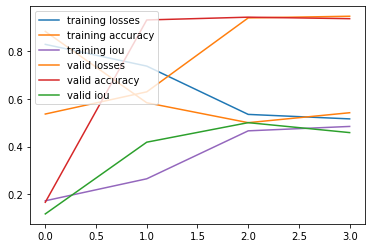

None

max valid iou: tensor(0.5001, device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
# >>>>>>>>>>>>>>>>>>>>>>> SECTION 21: Train model & assess metrics <<<<<<<<<<<<<<<<<<<<<<< #
# Not specific to Transformer

import os
from IPython.display import display
import matplotlib.pyplot as plt

max_valid_iou = 0
start = 0

epochs = []
training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []


for i in range(start, train_config['epochs']):
  train_validation_loop(net, optimizer, scheduler, train_loader, valid_loader, 1, i)
  epochs.append(i)
  x = epochs
  plt.plot(x, training_losses, label='training losses')
  plt.plot(x, training_accuracies, 'tab:orange', label='training accuracy')
  plt.plot(x, training_ious, 'tab:purple', label='training iou')
  plt.plot(x, valid_losses, label='valid losses')
  plt.plot(x, valid_accuracies, 'tab:red',label='valid accuracy')
  plt.plot(x, valid_ious, 'tab:green',label='valid iou')
  plt.legend(loc="upper left")

  display(plt.show())

  print("max valid iou:", max_valid_iou)

In [ ]:
rm -r chkpoints